<a href="https://colab.research.google.com/github/matule00/SGE/blob/main/cena_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

import statsmodels.formula.api as smf


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 220)

In [55]:
SVR = pd.read_csv('SVR_11_12.csv')
SVR['Time'] = pd.to_datetime(SVR['Time'])

SO = pd.read_csv('odchylka_moje.csv')
SO['Time'] = pd.to_datetime(SO['Time'])

RE = pd.read_csv('RE_cena_moje.csv')
RE['Time'] = pd.to_datetime(RE['Time'])

data = pd.merge(RE, SO, on='Time')

data = pd.merge(data, SVR, on='Time')
data.drop(columns=['rr_p', 'rr_m', 'mFRR+ [eur]', 'mFRR- [eur]', 'mFRR5 [eur]', 'mfrr_p', 'mfrr_m'], inplace=True)
data.rename(columns={'Aktuální odchylka [MW]': 'SO', 'aFRR [eur]': 'cena'}, inplace=True)
data['cena'] = pd.to_numeric(data['cena'], errors='coerce')
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

print(data.head())
print(data.info())

                 Time       cena         SO    afrr_p  afrr_m  mfrr5
0 2024-11-28 09:06:00  237.64984 -65.543770  75.02734     0.0    0.0
1 2024-11-28 09:07:00  187.94983 -42.624687  77.96964     0.0    0.0
2 2024-11-28 09:08:00  169.51376 -15.013090  76.93359     0.0    0.0
3 2024-11-28 09:09:00  167.33347  -0.357384  75.89848     0.0    0.0
4 2024-11-28 09:10:00  167.19435 -10.509396  75.14953     0.0    0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16167 entries, 0 to 16166
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    16167 non-null  datetime64[ns]
 1   cena    16167 non-null  float64       
 2   SO      16167 non-null  float64       
 3   afrr_p  16167 non-null  float64       
 4   afrr_m  16167 non-null  float64       
 5   mfrr5   16167 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 758.0 KB
None


In [68]:
data['cena_shifted'] = data['cena'] - data['cena'].min() + 1  # Shift to make positive
model_shifted = smf.ols(formula="np.log(cena_shifted) ~ SO + afrr_p + afrr_m + mfrr5", data=data).fit()
print(model_shifted.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log(cena_shifted)   R-squared:                       0.469
Model:                              OLS   Adj. R-squared:                  0.469
Method:                   Least Squares   F-statistic:                     3567.
Date:                  Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                          08:11:23   Log-Likelihood:                 2120.0
No. Observations:                 16167   AIC:                            -4230.
Df Residuals:                     16162   BIC:                            -4192.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1570      0.002

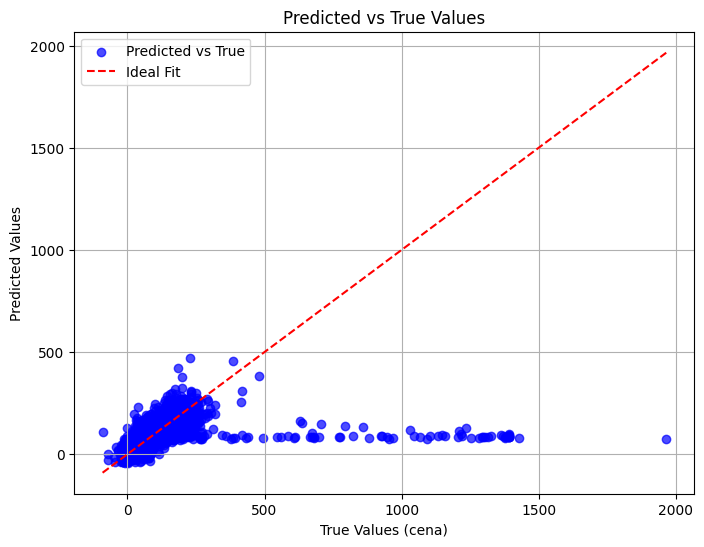

In [70]:
data['predicted'] = np.exp(model_shifted.predict(data)) + data['cena'].min() - 1

plt.figure(figsize=(8, 6))
plt.scatter(data['cena'], data['predicted'], alpha=0.7, color='blue', label='Predicted vs True')
plt.plot([data['cena'].min(), data['cena'].max()], [data['cena'].min(), data['cena'].max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values (cena)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.legend()
plt.grid()
plt.show()

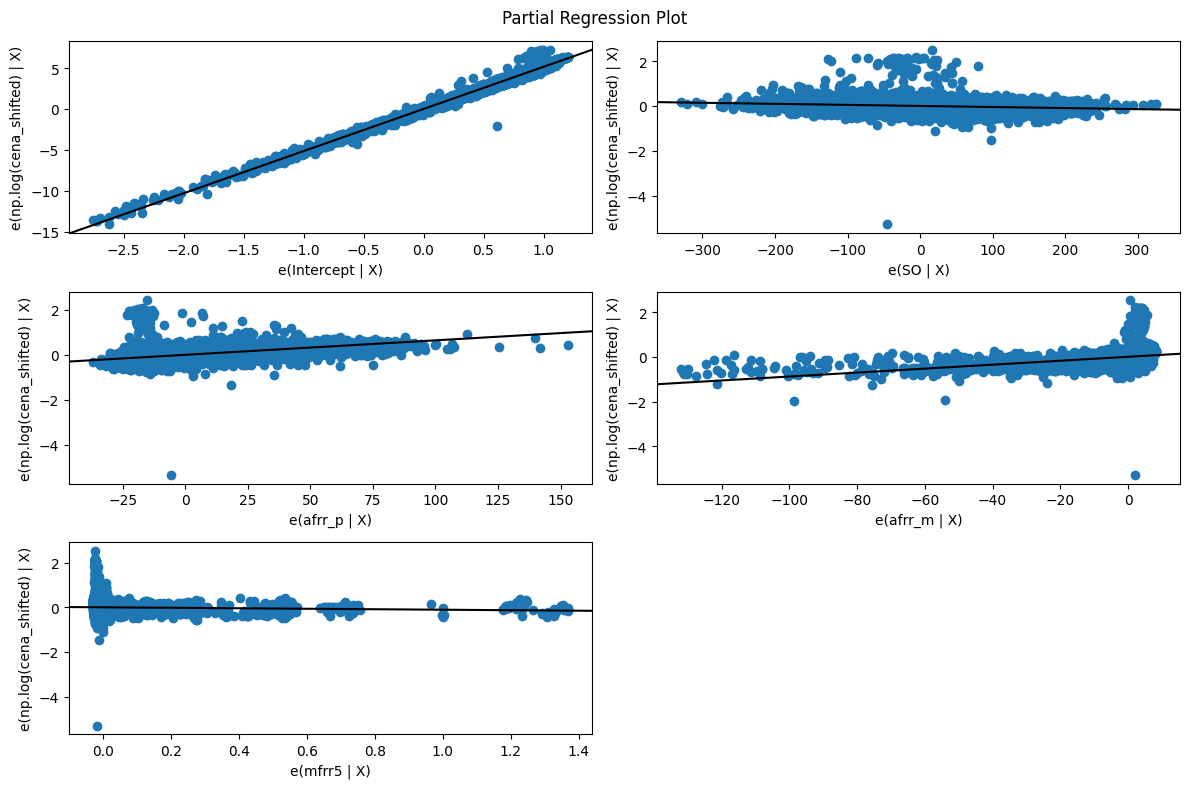

In [71]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_partregress_grid(model_shifted, fig=fig)
plt.tight_layout()
plt.show()